<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#DummyRegressor" data-toc-modified-id="DummyRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>DummyRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#DummyRegressor" data-toc-modified-id="DummyRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>DummyRegressor</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

## Подготовка

In [1]:
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.dummy import DummyRegressor
import warnings
warnings.filterwarnings('ignore')

/Users/vladimirtsebrikov/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Остортируем по индексу на всякий случай

In [5]:
df.sort_index(inplace=True)

Ресемплируем по одному часу

In [6]:
df = df.resample('1H').sum()

In [7]:
df.index.year.unique()

Int64Index([2018], dtype='int64', name='datetime')

Данные приведены только за 2018 год

## Анализ

Разложим временной ряд на составляющие

In [8]:
decomposed_year = seasonal_decompose(df) 
decomposed_month = seasonal_decompose(df['2018-03-01':'2018-04-01']) 
decomposed_week = seasonal_decompose(df['2018-03-05':'2018-03-11']) #Неделя с понедельника по воскресенье

Text(0.5, 1.0, 'Seasonality')

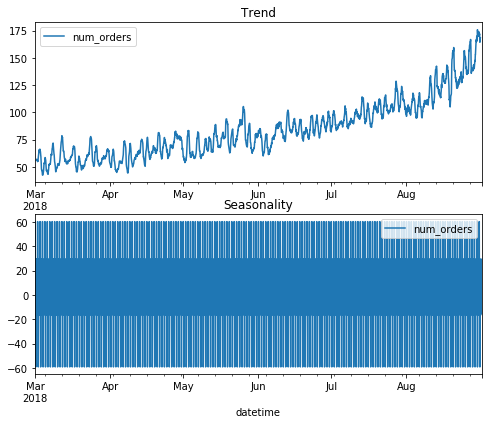

In [9]:
plt.figure(figsize=(8, 10))
plt.subplot(311)
decomposed_year.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_year.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

Виден тренд на увеличение количества заказов в году, но сезонность увидеть невозможно, для этого рассмотрим график для недели

Text(0.5, 1.0, 'Seasonality')

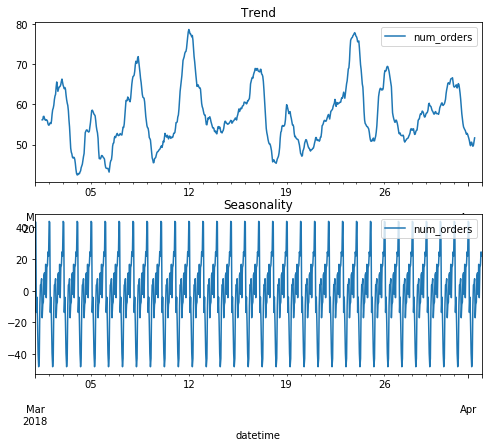

In [10]:
plt.figure(figsize=(8, 10))
plt.subplot(311)
decomposed_month.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_month.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

Сезоннность прослеживается в суточных колебаниях количества заказов (мало заказов по утрам и увеличение к вечерам)

Text(0.5, 1.0, 'Seasonality')

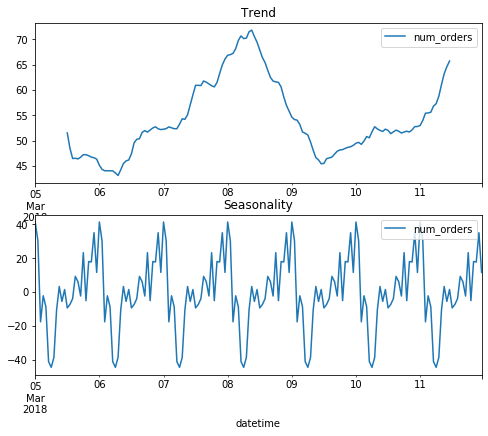

In [11]:
plt.figure(figsize=(8, 10))
plt.subplot(311)
decomposed_week.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_week.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

Виден тренд на повышенный спрос на такси по четвергам и воскресеньям. Также видна выраженная сезонность по времени суток.

## Обучение

Создадим признаки для обучения

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Предположим, что для успешного обучения модели нужны будут данные за предыдущую неделю (168 часов)

In [13]:
make_features(df, 168, 168)

Разделим данные для обучения и проверки

In [14]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [15]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

In [16]:
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### LinearRegression

In [17]:
model_linear = LinearRegression().fit(features_train, target_train)

### LightGBM

In [18]:
LGBM = LGBMRegressor(random_state=2019)
parameters = { 'num_leaves'  : range(10,100,10),
              'n_estimators': range(10,100,10),}

grid_lgbm = GridSearchCV(LGBM, parameters, cv = TimeSeriesSplit(3)).fit(features_train, target_train)

### DummyRegressor

In [19]:
dummy_median = DummyRegressor(strategy="median")
dummy_median.fit(features_train, target_train)

DummyRegressor(strategy='median')

## Тестирование

### LinearRegression

In [20]:
mean_squared_error(target_test, model_linear.predict(features_test))**0.5

35.559690335170316

### LightGBM

In [21]:
mean_squared_error(target_test, grid_lgbm.best_estimator_.predict(features_test))**0.5

36.62340737249001

### DummyRegressor

In [22]:
mean_squared_error(target_test, dummy_median.predict(features_test))**0.5

86.41465855206327

## Вывод

Наилучший результат на тестовых данных показала модель линейной регрессии с показателем RMSE = 35.5 (при требуемом не более 48), что также значительно лучше чем модель DummyRegressor на основе медианных значений